In [1]:
%load_ext autoreload
%autoreload 2

Add the autoreload command so that changes made on the forestplot library can be reflected automatically

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import forestplot as fp
from datetime import datetime
# Please use the version of forestplot found in my repository:
# https://github.com/takua624/forestplot
# I'm trying to tweak the original version (https://github.com/lsys/forestplot) to do what we want to do in the MEP

## Example Data

https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD014624.pub2/full

Wilson et al. (2025) Brexanolone, zuranolone and related neurosteroid GABAA receptor positive allosteric modulators for postnatal depression

In [6]:
from scraping_utils import scrape_review_data

def Cochrane_forestplot_postAug2023(data_dir="", data_package_dir="", n_study_thresh=0, save_fig=False, fig_dir="", **kwargs):
    # Cochrane's new Focused Review Format launched in August 2023.
    # This function expects the input data to be in that format
    '''
    data_dir: this directory contains unzipped folders downloaded from Cochrane Library. Its structure should be:
        {data_dir}
            - {data_package_dir}-dataPackage"
                - {data_package_ID}-data-rows.csv
                - {data_package_ID}-overall-estimates-and-settings.csv
                - {data_package_ID}-subgroup-estimates.csv
            - {data_package_dir}-other-references
            - {data_package_dir}-study-data
    data_package_dir: something like "CD014624". Sometimes it also contains suffixes like "CD006475-SUP-08".
        removing the suffixes (if any) yields the variable data_package_ID
    n_study_thresh (default 0): for each analysis subgroup, if it contains less than n_study_thresh studies, we don't plot it.
    '''
    data_package_ID = data_package_dir.split("-")[0]

    # subtotal values of analyses within subgroups are stored in a separate file as those without a subgroup
    df = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-data-rows.csv")
    est = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-overall-estimates-and-settings.csv")
    est_g = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-subgroup-estimates.csv")

    # determine the common columns between the two tables containing subtotal values
    est_cols = est.columns
    est_g_cols = est_g.columns
    common_cols = [cc for cc in est_cols if cc in est_g_cols]

    for ag in df["Analysis group"].unique():
        ag_df = df[(df["Analysis group"]==ag)]
        for an in ag_df["Analysis number"].unique():
            an_df = ag_df[ag_df["Analysis number"]==an].reset_index(drop=True)
            # print(f"Group: {ag}, Analysis: {an}")
            stats_method = est[(est["Analysis group"]==ag)&(est["Analysis number"]==an)].reset_index().loc[0,"Statistical method"]
            
            # if an analysis doesn't contain subgroups, we still assign a dummy subgroup to it, so that the following steps can be consistent
            if an_df["Subgroup"].isna().all():
                an_df["Subgroup"] = ""
                an_df["Subgroup number"] = 0
                
            if "Subgroup number" not in an_df.columns:
                an_df["Subgroup number"] = pd.factorize(an_df["Subgroup"])[0]
                
            logscale = est[(est["Analysis group"]==ag)&(est["Analysis number"]==an)].reset_index().loc[0,"Log-scale data"]
            
            for sg in an_df["Subgroup number"].unique():
                sg_df = an_df[an_df["Subgroup number"]==sg].reset_index(drop=True)
                sg_name = sg_df["Subgroup"].unique()[0]
                study_number = f"Study: {data_package_ID}, Group: {ag}, Analysis: {an}" + (f", Subgroup: {int(sg)}" if sg!=0 else "")
                study_header =  f"{sg_df["Analysis name"][0]}: {sg_name}"
                print(study_number + "\n" + study_header) # in later version, should include this as figure title

                # if an analysis doesn't include enough number of studies, we don't plot it.
                if sg_df.shape[0]<n_study_thresh:
                    print(f"Less than {n_study_thresh} studies are included, skip.\n")
                    continue

                # add two indicator columns to take advantage of the modified version of forestplot
                # "Is_total" indicates the row contains subtotal values
                # "Is_total_stats" indicates the row contains a statement about the test stats of the subtotal values
                sg_df["Is_total"] = 0
                sg_df["Is_total_stats"] = 0
                
                if sg==0:
                    # meaning actually no subgroup, pull data from the overall estimates file
                    est_stats = est[(est["Analysis group"]==ag)&(est["Analysis number"]==an)][common_cols].reset_index(drop=True)
                if sg!=0:
                    # pull data from subgroup estimate file
                    est_stats = est_g[(est_g["Analysis group"]==ag)&(est_g["Analysis number"]==an)&(est_g["Subgroup number"]==sg)][common_cols].reset_index(drop=True)
                
                  
                if est_stats.shape[0]>1:
                    print("!! Something's not quite right !!")
    
                # add an empty column to fill in subtotal values
                sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
                sg_df.loc[len(sg_df)-1, "Weight"] = 100
                sg_df.loc[len(sg_df)-1, "Study"] = "Subtotal"
                sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
                sg_df.loc[len(sg_df)-1, "Is_total"] = 1
                sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 0
                for col in ["Mean", "CI start", "CI end"]:
                        sg_df.loc[len(sg_df)-1, col] = est_stats.loc[0,col]
                # Configurations of the plots can be different depending on the stats method used.
                # Should check out Cochrane manual for all available stats methods, other than MH and IV.
                # There seem to be "Peto/O-E" (are they the same thing?), and also a "DerSimonian and Laird"
                # (https://documentation.cochrane.org/revman-kb/files/210600101/210600103/1/1654774257333/Statistical_methods_in_revman.pdf)
                if stats_method=="MH":
                    annote = ["Experimental cases", "Experimental N",  "Control cases", "Control N",  "Weight", "est_ci"]
                    annoteheaders = ["Experiment Events", "Experiment Total", "Placebo Events", "Placebo Total", "Weight", "Risk Ratio, M-H, Random, 95% CI"]
                    # fill in the subtotal values
                    for col in annote[:-2]:
                        sg_df.loc[len(sg_df)-1, col] = int(est_stats.loc[0,col])
                    xticks = [0.01, 0.1, 1, 10, 100] # xticks have to be dynamically determined from the data, will consider this later!
                if stats_method=="IV":
                    annote = ["GIV Mean", "GIV SE", "Weight", "est_ci"]
                    annoteheaders = ["MD", "SE", "Weight", "Mean Diff., IV, Random, 95% CI"]
                    # fill in the subtotal values, which is empty for IV method
                    sg_df.loc[len(sg_df)-1, "GIV Mean"] = ""
                    sg_df.loc[len(sg_df)-1, "GIV SE"] = ""
                    xticks = [-20, -10, 0, 10, 20] # xticks have to be dynamically determined from the data, will consider this later!
    
                # add rows to contain info regarding subtotal stats
                # row 1: Test for total effect
                sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
                sg_df.loc[len(sg_df)-1, "Weight"] = 0
                sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
                sg_df.loc[len(sg_df)-1, "Is_total"] = 0
                sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 1
                effect_z = est_stats.loc[0, "Effect Z"]
                effect_p = est_stats.loc[0, "Effect P"]
                sg_df.loc[len(sg_df)-1, "Study"] = f"Test for overall effect: Z = {effect_z:.2f} (P = {effect_p:.3f})"
    
                # row 2: Heterogeneity
                sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
                sg_df.loc[len(sg_df)-1, "Weight"] = 0
                sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
                sg_df.loc[len(sg_df)-1, "Is_total"] = 0
                sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 1
                tau = est_stats.loc[0, "Heterogeneity Tau²"]
                chi = est_stats.loc[0, "Heterogeneity Chi²"]
                dof = est_stats.loc[0, "Heterogeneity df"]
                dof = 0 if pd.isnull(dof) else int(dof)
                het_p = est_stats.loc[0, "Heterogeneity P"]
                het_i = est_stats.loc[0, "Heterogeneity I²"]
                het_i = 0 if pd.isnull(het_i) else int(het_i) # should be int, think about how to handle NaN
                sg_df.loc[len(sg_df)-1, "Study"] = f"Heterogeneity: Tau² (DL) = {tau:.2f}; Chi² = {chi:.2f}, df = {dof} (P = {het_p:.2f}); I² = {het_i}%"

                # row 3: Study/analysis/group ID
                sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
                sg_df.loc[len(sg_df)-1, "Weight"] = 0
                sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
                sg_df.loc[len(sg_df)-1, "Is_total"] = 0
                sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 1
                sg_df.loc[len(sg_df)-1, "Study"] = study_number

                # figure height should be proportional to the number of rows
                figsize = (5, 0.4*sg_df.shape[0])
                
                # check out the meanings of the arguements of the forestplot function
                fig, ax = fp.forestplot(sg_df, estimate="Mean", ll="CI start", hl="CI end", capitalize="capitalize", varlabel="Study",
                      annote=annote, annoteheaders=annoteheaders, logscale=logscale, xticks=xticks, figsize=figsize,
                      weight_col="Weight", contains_total=True, total_col="Is_total", total_stats_col="Is_total_stats",
                      ylabel=study_header,
                      **{"xline":1, "xlinecolor":"#999999"}
                     )
                plt.show()
                if save_fig:
                    file_name = f"{fig_dir}/{data_package_ID}_G{int(ag):02d}A{int(an):02d}" + (f"SG{int(sg):02d}" if sg!=0 else "") + ".png"
                    fig.savefig(file_name, bbox_inches="tight")
    return

data_dir = "forest_plot_data"
data_package_dir_list = ["CD015314-SUP-07"]
# "CD013543","CD004025","CD014624", "CD006475-SUP-08", "CD015314-SUP-07", "CD008565", "CD013613", "CD013071"
n_study_thresh = 5
fig_dir = "plot_output"
save_fig = True

for data_package_dir in data_package_dir_list:
    DOI = "http://doi.org/10.1002/14651858." + data_package_dir.split("-")[0]
    print(DOI)
    scrape_review_data(DOI)
    
    
    kwargs = {"data_dir": data_dir,
              "data_package_dir": data_package_dir,
              "n_study_thresh": n_study_thresh,
              "fig_dir": fig_dir,
              "save_fig": save_fig}
    # Cochrane_forestplot_postAug2023(**kwargs)


http://doi.org/10.1002/14651858.CD015314
... There is a newer version, accessing...
... Latest URL: https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD015314.pub2/full
... published on 2025-04-15. 
Data is locked. Let's deal with it later.


## Explore the data columns
Investigate the difference between the data spreadsheet formats across time

CD009683(2017.04.14) vs CD012548(2021.08.05)
... -data-rows.csv
They have the same columns.
... -overall-estimates-and-settings.csv
They have the same columns.
... -subgroup-estimates.csv
They have the same columns.

CD009683(2017.04.14) vs CD008209(2022.10.06)
... -data-rows.csv
They have the same columns.
... -overall-estimates-and-settings.csv
They have the same columns.
... -subgroup-estimates.csv
They have the same columns.

CD009683(2017.04.14) vs CD008565(2023.07.18)
... -data-rows.csv
They DON'T have the same columns.
Extra columns in CD009683: {'Subgroup number', 'Applicability'}
... -overall-estimates-and-settings.csv
They DON'T have the same columns.
Extra columns in CD009683: {'Prediction interval', 'PI start', 'Tau² CI end', 'Heterogeneity estimator', 'Effect T', 'PI end', 'CI method', 'Tau² CI', 'Tau² CI start', 'CI/PI level'}
Extra columns in CD008565: {'Study CI', 'Estimate CI'}
... -subgroup-estimates.csv
They DON'T have the same columns.
Extra columns in CD009683: {'E

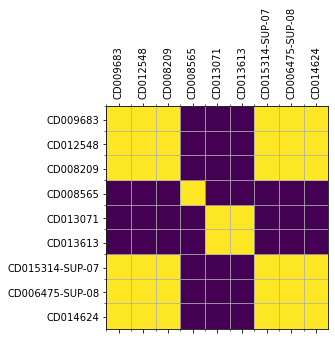

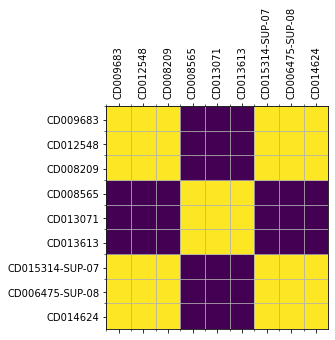

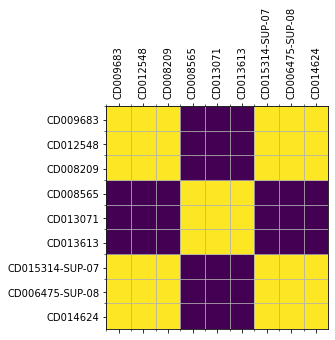

In [6]:
roster = pd.read_excel("forest_plot_data/compare_data_packages.xlsx")
dpack_invent = datetime.strptime("2023.04.25", "%Y.%m.%d").date()
dpack_currVer = datetime.strptime("2024.10.21", "%Y.%m.%d").date()
csv_cols = {"d_rows":{},
            "est":{},
            "est_g":{}}
csv_names = {"d_rows":"-data-rows.csv",
             "est":"-overall-estimates-and-settings.csv",
             "est_g":"-subgroup-estimates.csv"}
data_csv = ["d_rows", "est", "est_g"]

ignore_rows = ['Bias in measurement of the outcome (judgement)', 'Overall bias (support)', 'Overall bias (judgement)', 'Bias in selection of the reported result (support)', 'Bias due to missing outcome data (judgement)', 'Bias in selection of the reported result (judgement)', 'Bias due to deviations from intended interventions (support)', 'Bias in measurement of the outcome (support)', 'Bias due to missing outcome data (support)', 'Bias arising from the randomization process (support)', 'Bias due to deviations from intended interventions (judgement)', 'Bias arising from the randomization process (judgement)']
def comp_cols(cols1, cols2, ID1, ID2, verbose=False):
    
    cols1 = set(cols1) - set(ignore_rows)
    cols2 = set(cols2) - set(ignore_rows)
    more_former = cols1-cols2
    more_latter = cols2-cols1
    same = (more_former==set()) and (more_latter==set())
    if verbose:
        print(f"They{" DON'T"*(not same)} have the same columns.")
    if len(more_former)>0 and verbose:
        print(f"Extra columns in {ID1}: {more_former}")
    if len(more_latter)>0 and verbose:
        print(f"Extra columns in {ID2}: {more_latter}")
    return same
    
for ii,row in roster.iterrows():
    package_id = row["ID"]
    real_id = package_id.split("-")[0]
    pub_date = datetime.strptime(row["date"], "%Y.%m.%d").date()
    if pub_date < dpack_invent:
        data_dir = f"forest_plot_data/data-package[{real_id}]/{real_id}-files/{real_id}-data/{real_id}-analysis-data/"
    else:
        data_dir = f"forest_plot_data/{package_id}-dataPackage/{real_id}-analysis-data/"
    for dd in data_csv:
        csv_cols[dd][package_id] = pd.read_csv(data_dir+f"{real_id}{csv_names[dd]}").columns

n_packages = roster.shape[0]
sim_mat = {"d_rows": np.ones((n_packages, n_packages)),
           "est": np.ones((n_packages, n_packages)),
           "est_g": np.ones((n_packages, n_packages))}

for ii,rowi in roster.iterrows():
    for jj,rowj in roster.iterrows():
        if jj<=ii:
            continue
        print(f"{rowi["ID"]}({rowi["date"]}) vs {rowj["ID"]}({rowj["date"]})")
        # compare the columns
        for dd in data_csv:
            print(f"... {csv_names[dd]}")
            same = comp_cols(csv_cols[dd][rowi["ID"]], csv_cols[dd][rowj["ID"]], rowi["ID"], rowj["ID"], verbose=True)
            sim_mat[dd][ii,jj]=int(same)
            sim_mat[dd][jj,ii]=int(same)

        print()

figs = {"d_rows":None,
        "est":None,
        "est_g":None
       }
for dd in data_csv:
    figs[dd] = plt.matshow(sim_mat[dd])
    ax = plt.gca()
    ax.set_xticks(np.arange(9))
    ax.set_xticks(np.arange(9)-0.5, minor=True)
    ax.set_xticklabels(roster["ID"],rotation=90)
    ax.set_yticks(np.arange(9))
    ax.set_yticks(np.arange(9)-0.55, minor=True)
    ax.set_yticklabels(roster["ID"])
    ax.grid(visible=True, which="minor")
plt.show()
    

## Scrap

In [3]:
# an example of the weighted total calculation using Mantel-Haenszel random-effects model
# CD014624 analysis 2.1, subgroup 2

x1 = 49
xN1 = 77
x2 = 47
xN2 = 98

y1 = 33
yN1 = 76
y2 = 24
yN2 = 98

w1 = 0.603
w2 = 0.397
e1 = 1.47
e2 = 1.96

rx1 = x1/xN1
rx2 = x2/xN2
ry1 = y1/yN1
ry2 = y2/yN2

logr1 = np.log(rx1/ry1)
logr2 = np.log(rx2/ry2)
ans = np.exp(w1*logr1 + w2*logr2) # THIS IS IT!!

print(ans)

1.6442960216275762


     n         r          CI95%     p-val   BF10  power       var    hl    ll  \
0  706  0.090373    [0.02 0.16]  0.016309  0.839   0.67       age  0.16  0.02   
1  706  0.048081  [-0.03  0.12]  0.201948  0.106   0.25  clerical  0.12 -0.03   
2  706  0.041229  [-0.03  0.11]  0.273948  0.086   0.19  construc  0.11 -0.03   

    moerror       group                      label  
0  0.069627         age                   in years  
1  0.071919  occupation      =1 if clerical worker  
2  0.068771  occupation  =1 if construction worker  


<Axes: xlabel='Pearson correlation', ylabel='Confidence interval'>

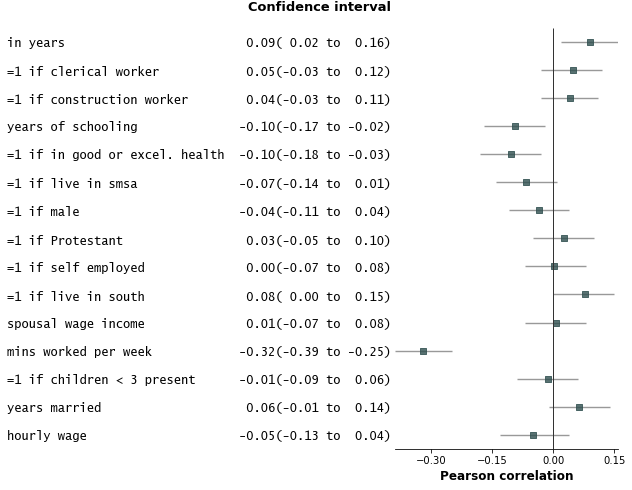

In [12]:
# forestplot module example usage
df = fp.load_data("sleep")
print(df.head(3))
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Pearson correlation",  # x-label title
              )

In [26]:
import random
print(3+2*random.random())

4.911097087112507
